In [1]:
import ray
import numpy as np

## the python tidyverse
import ibis
from ibis import _
import ibis.selectors as s
from plotnine import geom_point, ggplot, aes, geom_density, geom_bar

## download & upload saved model weights
from huggingface_hub import hf_hub_download, HfApi, login
api = HfApi()

## our fisheries RL environments (do `%pip install -e ..` first if necessary)
from rl4fisheries import Asm, Asm2o
from rl4fisheries.utils.sb3 import load_sb3_agent

## Helper utility from stable_baselines3
from stable_baselines3.common.evaluation import evaluate_policy


RL models potentially take a while to train, and training is not necessarily deterministic.  Following best practices, we store all model weights of the trained neural network RL agents on HuggingFace, a git-based platform designed for machine learning applications.  

Here, we have already trained the PPO algorithm on both the 1-dimensional observation (manager observes only the total abundance) and 2-dimensional observation (manager observes total abundance and mean weight) scenarios.  We download our trained weights for both cases.  See the notebook on "Training RL agents" for details.

In [2]:
# revision can be "latest" or fixed hash or tag
revision = "d21aac2cf7acd04485ae97c4194954cdba038ce2"
ppo_1obs = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/PPO-Asm-v0-1.zip", revision=revision)
ppo_2obs = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/PPO-Asm2o-v0-1.zip", revision=revision)

We can create an instance of an agent using the trained weights for each scenario as follows:

In [3]:
ppo_agent = load_sb3_agent(algo = "PPO", env = Asm(), weights = ppo_1obs)
ppo2o_agent = load_sb3_agent(algo = "PPO", env = Asm2o(), weights = ppo_2obs)

We can evaluate how well a given agent performs under a given environment using the `evaluate_policy` helper from stable-baselines3.  This simply simulates the environment to obtain observations, and shows those observations to the agent (manager) to determine what action it will take in the next timestep.  The function reports both the mean and standard deviation of the reward.

In [4]:
evaluate_policy(ppo_agent, Asm(), n_eval_episodes=10)

/opt/venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.


(39.65969898148906, 9.529769955115633)

In [5]:
evaluate_policy(ppo2o_agent, Asm2o(), n_eval_episodes=10)

(79.17429480809437, 16.842541803688626)

We can define custom managers without using RL.  This agent uses a fixed strategy.  The optimal strategy is selected using traditional (non-neural-network-based) machine learning optimization techniques (Bayesian inference using Gaussian Processes), see the notebook on optimal-fixed-policies. 

In [6]:
class fixed_effort:
    def __init__(self, effort):
        self.effort = effort[0]

    def predict(self, observation, **kwargs):
        action = self.effort * 2 - 1
        action = np.array([action], dtype=np.float32)
        return action, {}

msy_agent = fixed_effort([0.063])

In [7]:
evaluate_policy(msy_agent, Asm(), n_eval_episodes=100)

(44.82475018578937, 14.531605782747015)

It can be nice to see the whole distribution of scores.  We can tell `evaluate_policy` to return the full distribution

In [8]:
msy_rewards, _ = evaluate_policy(msy_agent, Asm(), n_eval_episodes=100, return_episode_rewards = True)
ppo_rewards, _ = evaluate_policy(ppo_agent, Asm(), n_eval_episodes=100, return_episode_rewards = True)
ppo2o_rewards, _ = evaluate_policy(ppo2o_agent, Asm2o(), n_eval_episodes=100, return_episode_rewards = True)


In [9]:
df = (ibis.memtable(
    {"msy": msy_rewards,
     "ppo": ppo_rewards,
     "ppo2o": ppo2o_rewards}).
    pivot_longer(s.c("msy", "ppo", "ppo2o"), 
                 names_to="model", 
                 values_to="reward")
     )

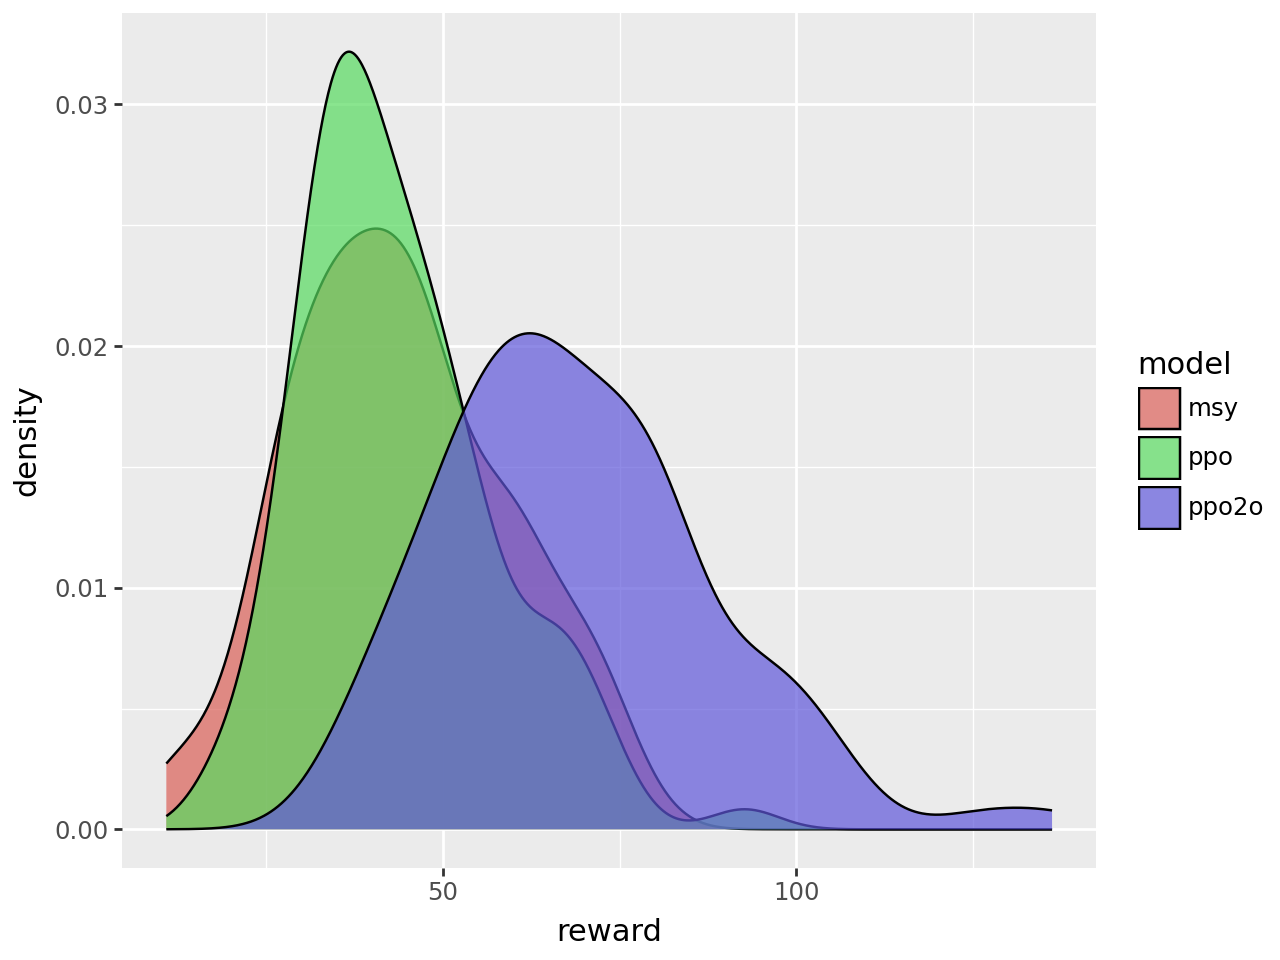

In [11]:
#ggplot(df, aes("x", fill="model")) + geom_bar(stat="bin", binwidth=1, alpha=0.5) + geom_density() 
ggplot(df, aes("reward", fill="model")) + geom_density(alpha=0.7) 

In a one-dimensional observation space we can easily visualize the policy (effort, expressed as mortality units between 0 & 1), as a function of the observed state (i.e. population abundance).  For the 2-observation case,  we consider test cases of looking at how the RL policy varies across increasing abundance given a fixed mean weight that is either low, medium, or high.  This demonstrates how this agent behaves differently with the additional information.  Note that for very low mean weights, it choses not to harvest.  This corresponds to an age structure that is largely juveniles, where it is better to wait until they reach maturity.  In contrast, when the mean weight is very high, this RL agent harvests aggressively.  These differences in response to extra information explain its superior performance.

In [12]:
df = []
observed = np.linspace(-1,1,201)

for obs in observed:
    action, d = ppo_agent.predict(np.array([obs]), deterministic=True)
    df.append([obs, *action, "PPO"])


for obs in observed:
    action, d = msy_agent.predict(np.array([obs]), deterministic=True)
    df.append([obs, *action, "MSY"])


# PPO-2obs at three different mean weights:
for obs in observed:
    action, d = ppo2o_agent.predict(np.array([obs,-0.5]), deterministic=True)
    df.append([obs, *action, "PPO2o_low"])
for obs in observed:
    action, d = ppo2o_agent.predict(np.array([obs,0.5]), deterministic=True)
    df.append([obs, *action, "PPO2o_high"])    
for obs in observed:
    action, d = ppo2o_agent.predict(np.array([obs,0]), deterministic=True)
    df.append([obs, *action, "PPO2o_med"])


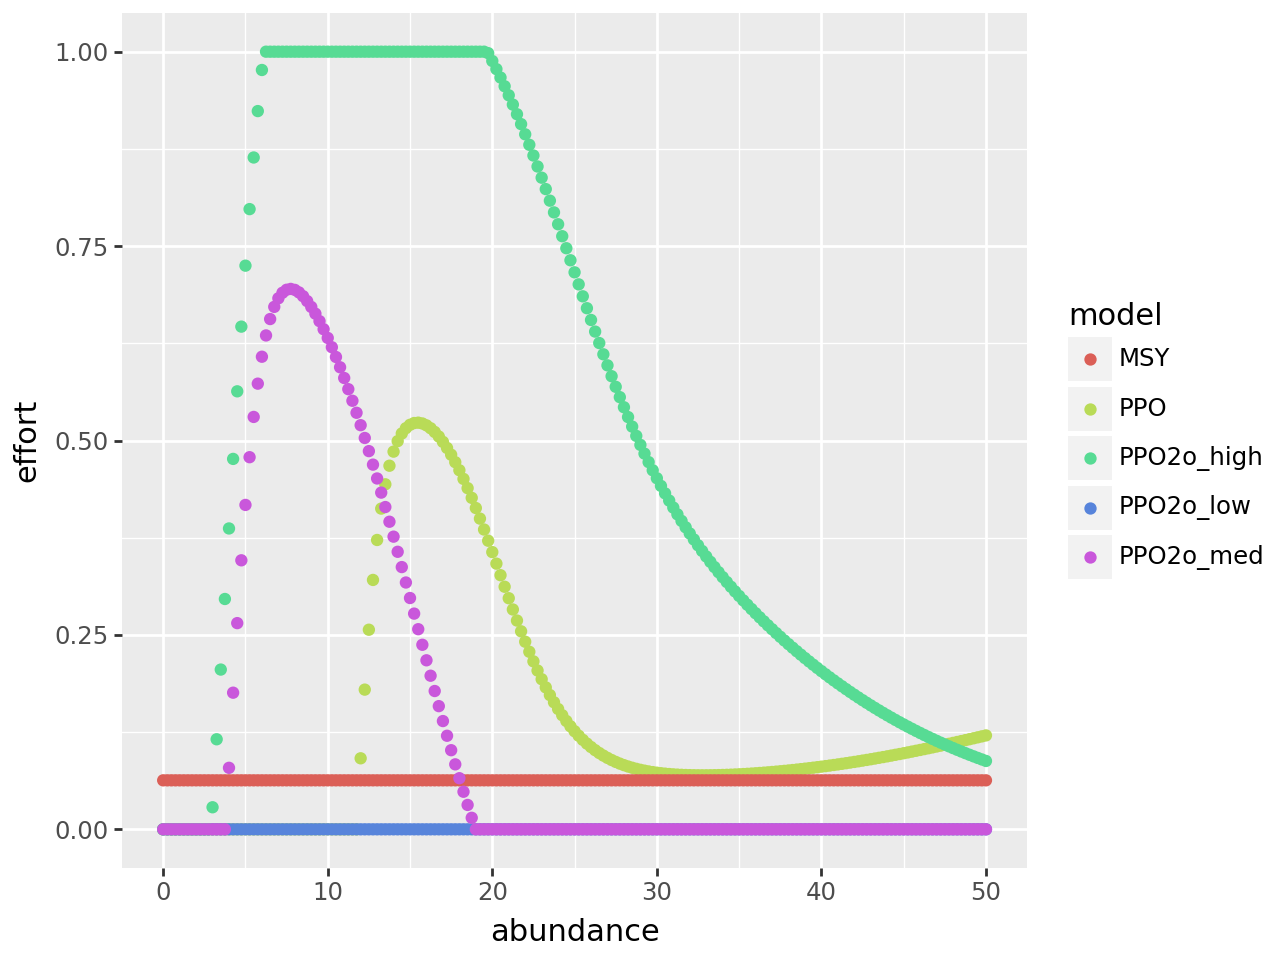

In [13]:
from ibis import _
env = Asm()
df2 = (ibis.memtable(df, columns=['obs', 'action', 'model']).
       mutate(abundance = (_.obs + 1) * env.bound / 2).
       mutate(effort = (_.action + 1) / 2).
       mutate(escapement = _.abundance * (1. - _.effort))
      )
df2

ggplot(df2, aes("abundance", "effort", color="model")) + geom_point()